In [2]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [3]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [4]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [5]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run2"
    model = EEGNet_IE_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_IE_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7187887932740006


Iterations:   0%|                                   | 1/300 [00:03<16:30,  3.31s/it]

Epoch:  0
t_loss:  0.7187887932740006 , v_loss:  0.6870031356811523
t_acc:  0.5026455026455027 , v_acc:  0.6583850931677019
t_recall:  0.5139779854792002 , v_recall:  0.5159459459459459
t_prec:  0.5118647826022797 , v_prec:  0.5328020756115641
t_f:  0.48746261564692406 , v_f:  0.4927536231884058
////////


Iterations:   1%|▏                                  | 2/300 [00:04<09:00,  1.81s/it]

Epoch  1 , loss 0.678608986676908
Epoch  2 , loss 0.655304818761115


Iterations:   1%|▎                                  | 3/300 [00:05<07:45,  1.57s/it]

Epoch:  2
t_loss:  0.655304818761115 , v_loss:  0.6756054560343424
t_acc:  0.578275754746343 , v_acc:  0.6770186335403726
t_recall:  0.5254978657992616 , v_recall:  0.501981981981982
t_prec:  0.5235746263353626 , v_prec:  0.5118279569892473
t_f:  0.5229716476125162 , v_f:  0.43796992481203006
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:05,  1.24s/it]

Epoch  3 , loss 0.6327469629399917
Epoch  4 , loss 0.6051731693978403


Iterations:   2%|▌                                  | 5/300 [00:07<06:06,  1.24s/it]

Epoch:  4
t_loss:  0.6051731693978403 , v_loss:  0.6649429400761923
t_acc:  0.6258948023653906 , v_acc:  0.6770186335403726
t_recall:  0.5157333827424823 , v_recall:  0.501981981981982
t_prec:  0.5199233319159142 , v_prec:  0.5118279569892473
t_f:  0.5118502545642073 , v_f:  0.43796992481203006
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:14,  1.07s/it]

Epoch  5 , loss 0.5913067191254859
Epoch  6 , loss 0.5699857052634744


Iterations:   2%|▊                                  | 7/300 [00:09<05:32,  1.13s/it]

Epoch:  6
t_loss:  0.5699857052634744 , v_loss:  0.6553887724876404
t_acc:  0.6623093681917211 , v_acc:  0.6894409937888198
t_recall:  0.513729567258204 , v_recall:  0.510990990990991
t_prec:  0.5285967891324482 , v_prec:  0.5971337579617835
t_f:  0.4904407905209056 , v_f:  0.4437534549474848
////////


Iterations:   3%|▉                                  | 8/300 [00:10<04:56,  1.02s/it]

Epoch  7 , loss 0.5545885843389174
Epoch  8 , loss 0.5386586370421391


Iterations:   3%|█                                  | 9/300 [00:11<05:18,  1.09s/it]

Epoch:  8
t_loss:  0.5386586370421391 , v_loss:  0.6496353546778361
t_acc:  0.6862745098039216 , v_acc:  0.6832298136645962
t_recall:  0.518591564760297 , v_recall:  0.4954954954954955
t_prec:  0.56560420507489 , v_prec:  0.34375
t_f:  0.47817781535828086 , v_f:  0.40590405904059035
////////


Iterations:   3%|█▏                                | 10/300 [00:12<04:45,  1.01it/s]

Epoch  9 , loss 0.5275582864004023
Epoch  10 , loss 0.5128797795258316


Iterations:   4%|█▏                                | 11/300 [00:13<05:10,  1.08s/it]

Epoch:  10
t_loss:  0.5128797795258316 , v_loss:  0.647763709227244
t_acc:  0.6862745098039216 , v_acc:  0.6894409937888198
t_recall:  0.509390483248926 , v_recall:  0.5
t_prec:  0.5470691292004715 , v_prec:  0.3447204968944099
t_f:  0.45501319261213713 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<04:39,  1.03it/s]

Epoch  11 , loss 0.5014692907239876
Epoch  12 , loss 0.4962338092280369


Iterations:   4%|█▍                                | 13/300 [00:15<05:02,  1.06s/it]

Epoch:  12
t_loss:  0.4962338092280369 , v_loss:  0.6479450563589731
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5072837320377156 , v_recall:  0.5
t_prec:  0.576653089522489 , v_prec:  0.3447204968944099
t_f:  0.4373198016376427 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<04:32,  1.05it/s]

Epoch  13 , loss 0.48887454353126825
Epoch  14 , loss 0.4812183269098693


Iterations:   5%|█▋                                | 15/300 [00:17<04:55,  1.04s/it]

Epoch:  14
t_loss:  0.4812183269098693 , v_loss:  0.649589349826177
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5063257435390676 , v_recall:  0.5
t_prec:  0.5991637740612181 , v_prec:  0.3447204968944099
t_f:  0.43103789176966834 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:27,  1.06it/s]

Epoch  15 , loss 0.4771970779288049
Epoch  16 , loss 0.4776691765177484


Iterations:   6%|█▉                                | 17/300 [00:19<04:50,  1.02s/it]

Epoch:  16
t_loss:  0.4776691765177484 , v_loss:  0.6512853105862936
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5028115178216055 , v_recall:  0.5
t_prec:  0.6131101376720901 , v_prec:  0.3447204968944099
t_f:  0.4190986232950797 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<04:25,  1.06it/s]

Epoch  17 , loss 0.47273390959290895
Epoch  18 , loss 0.46826701655107383


Iterations:   6%|██▏                               | 19/300 [00:21<04:52,  1.04s/it]

Epoch:  18
t_loss:  0.46826701655107383 , v_loss:  0.6546951333681742
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.5007342748521156 , v_recall:  0.5
t_prec:  0.521875425923402 , v_prec:  0.3447204968944099
t_f:  0.41720859785375913 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:24,  1.06it/s]

Epoch  19 , loss 0.46033605231958274
Epoch  20 , loss 0.4572233312270221


Iterations:   7%|██▍                               | 21/300 [00:23<04:52,  1.05s/it]

Epoch:  20
t_loss:  0.4572233312270221 , v_loss:  0.6567367811997732
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5022364502271449 , v_recall:  0.5
t_prec:  0.6175120192307693 , v_prec:  0.3447204968944099
t_f:  0.41718316736553546 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:23,  1.05it/s]

Epoch  21 , loss 0.45801454256562624
Epoch  22 , loss 0.4553716936532189


Iterations:   8%|██▌                               | 23/300 [00:25<04:44,  1.03s/it]

Epoch:  22
t_loss:  0.4553716936532189 , v_loss:  0.6582648654778799
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:18,  1.07it/s]

Epoch  23 , loss 0.4552052599542281
Epoch  24 , loss 0.45013584225785497


Iterations:   8%|██▊                               | 25/300 [00:27<04:40,  1.02s/it]

Epoch:  24
t_loss:  0.45013584225785497 , v_loss:  0.6600398818651835
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:17,  1.07it/s]

Epoch  25 , loss 0.45093394669831965
Epoch  26 , loss 0.4498046636581421


Iterations:   9%|███                               | 27/300 [00:29<04:39,  1.02s/it]

Epoch:  26
t_loss:  0.4498046636581421 , v_loss:  0.6613551576932272
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:14,  1.07it/s]

Epoch  27 , loss 0.45508838517993105
Epoch  28 , loss 0.4489855503334719


Iterations:  10%|███▎                              | 29/300 [00:31<04:41,  1.04s/it]

Epoch:  28
t_loss:  0.4489855503334719 , v_loss:  0.6624882519245148
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:15,  1.06it/s]

Epoch  29 , loss 0.4510025405416302
Epoch  30 , loss 0.4452814979880464


Iterations:  10%|███▌                              | 31/300 [00:33<04:37,  1.03s/it]

Epoch:  30
t_loss:  0.4452814979880464 , v_loss:  0.6595554600159327
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5028437710160443 , v_recall:  0.5
t_prec:  0.7769806612601372 , v_prec:  0.3447204968944099
t_f:  0.41667765984343347 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:11,  1.07it/s]

Epoch  31 , loss 0.4455600328305188
Epoch  32 , loss 0.44860297850534026


Iterations:  11%|███▋                              | 33/300 [00:35<04:33,  1.02s/it]

Epoch:  32
t_loss:  0.44860297850534026 , v_loss:  0.6579234848419825
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:08,  1.07it/s]

Epoch  33 , loss 0.44736403752775755
Epoch  34 , loss 0.4500657214837916


Iterations:  12%|███▉                              | 35/300 [00:36<04:30,  1.02s/it]

Epoch:  34
t_loss:  0.4500657214837916 , v_loss:  0.6521440098683039
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:37<04:06,  1.07it/s]

Epoch  35 , loss 0.44176697263530657
Epoch  36 , loss 0.437293375824012


Iterations:  12%|████▏                             | 37/300 [00:38<04:33,  1.04s/it]

Epoch:  36
t_loss:  0.437293375824012 , v_loss:  0.6463366250197092
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:08,  1.05it/s]

Epoch  37 , loss 0.4419449164586909
Epoch  38 , loss 0.4398832718531291


Iterations:  13%|████▍                             | 39/300 [00:40<04:29,  1.03s/it]

Epoch:  38
t_loss:  0.4398832718531291 , v_loss:  0.6418314526478449
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.4999677468055613 , v_recall:  0.5
t_prec:  0.49779893849516077 , v_prec:  0.3447204968944099
t_f:  0.41274588925137695 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:04,  1.06it/s]

Epoch  39 , loss 0.44519320773143395
Epoch  40 , loss 0.4395623779764362


Iterations:  14%|████▋                             | 41/300 [00:42<04:28,  1.04s/it]

Epoch:  40
t_loss:  0.4395623779764362 , v_loss:  0.6388934900363287
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.502108809925749 , v_recall:  0.5
t_prec:  0.7053961322520275 , v_prec:  0.3447204968944099
t_f:  0.41547864167250537 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:04,  1.05it/s]

Epoch  41 , loss 0.4410070449698205
Epoch  42 , loss 0.4338778917695962


Iterations:  14%|████▊                             | 43/300 [00:44<04:27,  1.04s/it]

Epoch:  42
t_loss:  0.4338778917695962 , v_loss:  0.6361087312301
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5057513621827864 , v_recall:  0.5
t_prec:  0.7313829787234043 , v_prec:  0.3447204968944099
t_f:  0.42385523641037076 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:03,  1.05it/s]

Epoch  43 , loss 0.443358134989645
Epoch  44 , loss 0.43404533933190736


Iterations:  15%|█████                             | 45/300 [00:46<04:26,  1.04s/it]

Epoch:  44
t_loss:  0.43404533933190736 , v_loss:  0.6303441574176153
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:03,  1.05it/s]

Epoch  45 , loss 0.43201823766325037
Epoch  46 , loss 0.44093876843358953


Iterations:  16%|█████▎                            | 47/300 [00:48<04:21,  1.03s/it]

Epoch:  46
t_loss:  0.44093876843358953 , v_loss:  0.62403604388237
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5041215465063614 , v_recall:  0.5
t_prec:  0.6343984962406015 , v_prec:  0.3447204968944099
t_f:  0.422183377407258 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<03:58,  1.06it/s]

Epoch  47 , loss 0.4369782431452882
Epoch  48 , loss 0.4360525941147524


Iterations:  16%|█████▌                            | 49/300 [00:50<04:20,  1.04s/it]

Epoch:  48
t_loss:  0.4360525941147524 , v_loss:  0.6205630153417587
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5078601721085354 , v_recall:  0.5
t_prec:  0.7244825964252117 , v_prec:  0.3447204968944099
t_f:  0.42891539928991573 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:56,  1.06it/s]

Epoch  49 , loss 0.4382374835949318
Epoch  50 , loss 0.4312356494221033


Iterations:  17%|█████▊                            | 51/300 [00:52<04:18,  1.04s/it]

Epoch:  50
t_loss:  0.4312356494221033 , v_loss:  0.6171118418375651
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5047926874459587 , v_recall:  0.5
t_prec:  0.6821596244131456 , v_prec:  0.3447204968944099
t_f:  0.4225454303401451 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:56,  1.05it/s]

Epoch  51 , loss 0.43048229755139816
Epoch  52 , loss 0.4353741477517521


Iterations:  18%|██████                            | 53/300 [00:54<04:21,  1.06s/it]

Epoch:  52
t_loss:  0.4353741477517521 , v_loss:  0.6116882860660553
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5041853666570594 , v_recall:  0.51
t_prec:  0.6195319849482597 , v_prec:  0.846875
t_f:  0.42300355042128135 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:01,  1.02it/s]

Epoch  53 , loss 0.43338504316760046
Epoch  54 , loss 0.4389555226354038


Iterations:  18%|██████▏                           | 55/300 [00:57<04:23,  1.08s/it]

Epoch:  54
t_loss:  0.4389555226354038 , v_loss:  0.6104191392660141
t_acc:  0.6953003423591659 , v_acc:  0.6956521739130435
t_recall:  0.5020765567313102 , v_recall:  0.51
t_prec:  0.5835419274092616 , v_prec:  0.846875
t_f:  0.41790947001625695 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:01,  1.01it/s]

Epoch  55 , loss 0.4322132468223572
Epoch  56 , loss 0.43312818221017424


Iterations:  19%|██████▍                           | 57/300 [00:59<04:26,  1.10s/it]

Epoch:  56
t_loss:  0.43312818221017424 , v_loss:  0.6070808072884878
t_acc:  0.6949891067538126 , v_acc:  0.7018633540372671
t_recall:  0.5030029782736992 , v_recall:  0.52
t_prec:  0.5792160459559268 , v_prec:  0.8490566037735849
t_f:  0.4215796349827543 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:03,  1.01s/it]

Epoch  57 , loss 0.43352921219433055
Epoch  58 , loss 0.428450158998078


Iterations:  20%|██████▋                           | 59/300 [01:01<04:20,  1.08s/it]

Epoch:  58
t_loss:  0.428450158998078 , v_loss:  0.6045434723297755
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5054953953418152 , v_recall:  0.51
t_prec:  0.6346938775510205 , v_prec:  0.846875
t_f:  0.42605217404062706 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:03,  1.01s/it]

Epoch  59 , loss 0.4316759430894665
Epoch  60 , loss 0.43614979234396245


Iterations:  20%|██████▉                           | 61/300 [01:03<04:21,  1.10s/it]

Epoch:  60
t_loss:  0.43614979234396245 , v_loss:  0.6036847283442816
t_acc:  0.6959228135698724 , v_acc:  0.6956521739130435
t_recall:  0.5033865854160662 , v_recall:  0.51
t_prec:  0.6104323308270676 , v_prec:  0.846875
t_f:  0.4209981125404011 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:04<04:13,  1.07s/it]

Epoch  61 , loss 0.42505799263131383
Epoch  62 , loss 0.42641136926763196


Iterations:  21%|███████▏                          | 63/300 [01:05<04:26,  1.13s/it]

Epoch:  62
t_loss:  0.42641136926763196 , v_loss:  0.6009594450394312
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.506454070078643 , v_recall:  0.52
t_prec:  0.6639987445072191 , v_prec:  0.8490566037735849
t_f:  0.42735630095234944 , v_f:  0.44957264957264953
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<04:09,  1.06s/it]

Epoch  63 , loss 0.4293757934196323
Epoch  64 , loss 0.43381088037116855


Iterations:  22%|███████▎                          | 65/300 [01:07<04:24,  1.13s/it]

Epoch:  64
t_loss:  0.43381088037116855 , v_loss:  0.5971375753482183
t_acc:  0.6971677559912854 , v_acc:  0.7018633540372671
t_recall:  0.5062941765828083 , v_recall:  0.52
t_prec:  0.6394740577036151 , v_prec:  0.8490566037735849
t_f:  0.42802958714014333 , v_f:  0.44957264957264953
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<04:08,  1.06s/it]

Epoch  65 , loss 0.42706102074361313
Epoch  66 , loss 0.4340996777310091


Iterations:  22%|███████▌                          | 67/300 [01:09<04:20,  1.12s/it]

Epoch:  66
t_loss:  0.4340996777310091 , v_loss:  0.5959881693124771
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5087865936509244 , v_recall:  0.53
t_prec:  0.6830188679245283 , v_prec:  0.8512658227848101
t_f:  0.432471621032904 , v_f:  0.4692431787893666
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:57,  1.02s/it]

Epoch  67 , loss 0.42584453201761435
Epoch  68 , loss 0.42486729224522907


Iterations:  23%|███████▊                          | 69/300 [01:12<04:12,  1.09s/it]

Epoch:  68
t_loss:  0.42486729224522907 , v_loss:  0.5945433924595515
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5125252192530984 , v_recall:  0.53
t_prec:  0.7393767705382437 , v_prec:  0.8512658227848101
t_f:  0.4391063907949462 , v_f:  0.4692431787893666
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:48,  1.01it/s]

Epoch  69 , loss 0.4273547872024424
Epoch  70 , loss 0.43720481617777956


Iterations:  24%|████████                          | 71/300 [01:14<04:07,  1.08s/it]

Epoch:  70
t_loss:  0.43720481617777956 , v_loss:  0.5953057010968527
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5065178902293408 , v_recall:  0.51
t_prec:  0.6491988689915174 , v_prec:  0.846875
t_f:  0.428156146179402 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:47,  1.00it/s]

Epoch  71 , loss 0.4260518013262281
Epoch  72 , loss 0.4260376948936313


Iterations:  24%|████████▎                         | 73/300 [01:16<04:12,  1.11s/it]

Epoch:  72
t_loss:  0.4260376948936313 , v_loss:  0.5922330617904663
t_acc:  0.6974789915966386 , v_acc:  0.7018633540372671
t_recall:  0.5079555592154925 , v_recall:  0.52
t_prec:  0.6370115033091711 , v_prec:  0.8490566037735849
t_f:  0.43272645633043094 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<03:51,  1.03s/it]

Epoch  73 , loss 0.42634224015123706
Epoch  74 , loss 0.4232084242736592


Iterations:  25%|████████▌                         | 75/300 [01:18<04:14,  1.13s/it]

Epoch:  74
t_loss:  0.4232084242736592 , v_loss:  0.5912150243918101
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5123653257572638 , v_recall:  0.53
t_prec:  0.7129569807752916 , v_prec:  0.8512658227848101
t_f:  0.4397298334127713 , v_f:  0.4692431787893666
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:58,  1.06s/it]

Epoch  75 , loss 0.4271867316143185
Epoch  76 , loss 0.4190290877047707


Iterations:  26%|████████▋                         | 77/300 [01:20<04:26,  1.19s/it]

Epoch:  76
t_loss:  0.4190290877047707 , v_loss:  0.587140291929245
t_acc:  0.6984126984126984 , v_acc:  0.7204968944099379
t_recall:  0.5094893015467808 , v_recall:  0.55
t_prec:  0.6521678526887242 , v_prec:  0.8557692307692308
t_f:  0.4358260072247829 , v_f:  0.5066394279877425
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<04:10,  1.13s/it]

Epoch  77 , loss 0.4272329859873828
Epoch  78 , loss 0.42649835289693344


Iterations:  26%|████████▉                         | 79/300 [01:23<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.42649835289693344 , v_loss:  0.5849880774815878
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5128765732010266 , v_recall:  0.55
t_prec:  0.716421123858149 , v_prec:  0.8557692307692308
t_f:  0.44075928906173856 , v_f:  0.5066394279877425
////////


Iterations:  27%|█████████                         | 80/300 [01:24<04:16,  1.16s/it]

Epoch  79 , loss 0.42700520683737364
Epoch  80 , loss 0.42189473030613917


Iterations:  27%|█████████▏                        | 81/300 [01:25<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.42189473030613917 , v_loss:  0.5835675845543543
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5136431012475811 , v_recall:  0.55
t_prec:  0.6748179803735359 , v_prec:  0.8557692307692308
t_f:  0.4447415733243656 , v_f:  0.5066394279877425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:26<04:07,  1.13s/it]

Epoch  81 , loss 0.4243274851172578
Epoch  82 , loss 0.418639121686711


Iterations:  28%|█████████▍                        | 83/300 [01:27<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.418639121686711 , v_loss:  0.5799657106399536
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5151768435788694 , v_recall:  0.55
t_prec:  0.6844106463878327 , v_prec:  0.8557692307692308
t_f:  0.44777043865379496 , v_f:  0.5066394279877425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:28<03:53,  1.08s/it]

Epoch  83 , loss 0.4224657387125726
Epoch  84 , loss 0.4202461961437674


Iterations:  28%|█████████▋                        | 85/300 [01:30<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4202461961437674 , v_loss:  0.5799121459325155
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5176054404962874 , v_recall:  0.55
t_prec:  0.7176710484637314 , v_prec:  0.8557692307692308
t_f:  0.4513729057734361 , v_f:  0.5066394279877425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:30<03:36,  1.01s/it]

Epoch  85 , loss 0.43287794204319224
Epoch  86 , loss 0.4238993204107471


Iterations:  29%|█████████▊                        | 87/300 [01:32<04:01,  1.13s/it]

Epoch:  86
t_loss:  0.4238993204107471 , v_loss:  0.5779557277758917
t_acc:  0.6999688764394647 , v_acc:  0.7267080745341615
t_recall:  0.5129081401572858 , v_recall:  0.56
t_prec:  0.665400443178221 , v_prec:  0.8580645161290323
t_f:  0.44358718990092355 , v_f:  0.5244360902255639
////////


Iterations:  29%|█████████▉                        | 88/300 [01:32<03:39,  1.04s/it]

Epoch  87 , loss 0.42333157389771703
Epoch  88 , loss 0.4258541663487752


Iterations:  30%|██████████                        | 89/300 [01:34<04:03,  1.16s/it]

Epoch:  88
t_loss:  0.4258541663487752 , v_loss:  0.5767150372266769
t_acc:  0.7015250544662309 , v_acc:  0.7391304347826086
t_recall:  0.5169020463622515 , v_recall:  0.58
t_prec:  0.6703036840358447 , v_prec:  0.8627450980392157
t_f:  0.45288186947968617 , v_f:  0.5583855799373041
////////


Iterations:  30%|██████████▏                       | 90/300 [01:35<03:35,  1.03s/it]

Epoch  89 , loss 0.4253376400938221
Epoch  90 , loss 0.42376508198532403


Iterations:  30%|██████████▎                       | 91/300 [01:36<03:59,  1.14s/it]

Epoch:  90
t_loss:  0.42376508198532403 , v_loss:  0.5750081390142441
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5187240087289496 , v_recall:  0.5754954954954955
t_prec:  0.7537950664136622 , v_prec:  0.8062865497076024
t_f:  0.4521105829769373 , v_f:  0.5538441709093253
////////


Iterations:  31%|██████████▍                       | 92/300 [01:37<03:35,  1.04s/it]

Epoch  91 , loss 0.42317474122140925
Epoch  92 , loss 0.42523753233984407


Iterations:  31%|██████████▌                       | 93/300 [01:38<03:49,  1.11s/it]

Epoch:  92
t_loss:  0.42523753233984407 , v_loss:  0.5728190690279007
t_acc:  0.7037037037037037 , v_acc:  0.7391304347826086
t_recall:  0.5184680418879785 , v_recall:  0.5854954954954955
t_prec:  0.7066317912388285 , v_prec:  0.8142384105960265
t_f:  0.45393041789254196 , v_f:  0.5698473282442748
////////


Iterations:  31%|██████████▋                       | 94/300 [01:39<03:35,  1.05s/it]

Epoch  93 , loss 0.4210168660855761
Epoch  94 , loss 0.41995834719900993


Iterations:  32%|██████████▊                       | 95/300 [01:40<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.41995834719900993 , v_loss:  0.5730272829532623
t_acc:  0.7046374105197635 , v_acc:  0.7391304347826086
t_recall:  0.5194267166248061 , v_recall:  0.5854954954954955
t_prec:  0.7208511899808605 , v_prec:  0.8142384105960265
t_f:  0.45522845519986893 , v_f:  0.5698473282442748
////////


Iterations:  32%|██████████▉                       | 96/300 [01:41<03:42,  1.09s/it]

Epoch  95 , loss 0.427788353433796
Epoch  96 , loss 0.4195734396869061


Iterations:  32%|██████████▉                       | 97/300 [01:43<03:51,  1.14s/it]

Epoch:  96
t_loss:  0.4195734396869061 , v_loss:  0.5739401678244272
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.516582945608762 , v_recall:  0.5954954954954955
t_prec:  0.7124881291547958 , v_prec:  0.8212121212121212
t_f:  0.4493591070181338 , v_f:  0.5853903649268262
////////


Iterations:  33%|███████████                       | 98/300 [01:44<03:35,  1.07s/it]

Epoch  97 , loss 0.41917478921366674
Epoch  98 , loss 0.41748643213627384


Iterations:  33%|███████████▏                      | 99/300 [01:45<03:48,  1.14s/it]

Epoch:  98
t_loss:  0.41748643213627384 , v_loss:  0.571019783616066
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5185002950824172 , v_recall:  0.5954954954954955
t_prec:  0.7460181782785389 , v_prec:  0.8212121212121212
t_f:  0.45196297868971613 , v_f:  0.5853903649268262
////////


Iterations:  33%|███████████                      | 100/300 [01:46<03:33,  1.07s/it]

Epoch  99 , loss 0.4194688598314921
Epoch  100 , loss 0.4182594149720435


Iterations:  34%|███████████                      | 101/300 [01:47<03:44,  1.13s/it]

Epoch:  100
t_loss:  0.4182594149720435 , v_loss:  0.5712258964776993
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5268717146347154 , v_recall:  0.5954954954954955
t_prec:  0.7432455936920223 , v_prec:  0.8212121212121212
t_f:  0.4698305186445374 , v_f:  0.5853903649268262
////////


Iterations:  34%|███████████▏                     | 102/300 [01:48<03:25,  1.04s/it]

Epoch  101 , loss 0.41944953098016624
Epoch  102 , loss 0.41928589694640217


Iterations:  34%|███████████▎                     | 103/300 [01:49<03:38,  1.11s/it]

Epoch:  102
t_loss:  0.41928589694640217 , v_loss:  0.5715807676315308
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5172856535046183 , v_recall:  0.5809909909909909
t_prec:  0.6874776714830104 , v_prec:  0.7724242424242425
t_f:  0.4524852195885727 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▍                     | 104/300 [01:50<03:19,  1.02s/it]

Epoch  103 , loss 0.4157625594559838
Epoch  104 , loss 0.42122387652303656


Iterations:  35%|███████████▌                     | 105/300 [01:51<03:35,  1.10s/it]

Epoch:  104
t_loss:  0.42122387652303656 , v_loss:  0.5713197340567907
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5201616777151014 , v_recall:  0.5809909909909909
t_prec:  0.7292065407339602 , v_prec:  0.7724242424242425
t_f:  0.4563765511846953 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▋                     | 106/300 [01:52<03:13,  1.01it/s]

Epoch  105 , loss 0.41630619705892075
Epoch  106 , loss 0.41657571465361354


Iterations:  36%|███████████▊                     | 107/300 [01:53<03:29,  1.09s/it]

Epoch:  106
t_loss:  0.41657571465361354 , v_loss:  0.5696563820044199
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5213756330547206 , v_recall:  0.590990990990991
t_prec:  0.7066021967526266 , v_prec:  0.7824384787472036
t_f:  0.4604017857142857 , v_f:  0.5805210918114144
////////


Iterations:  36%|███████████▉                     | 108/300 [01:54<03:11,  1.00it/s]

Epoch  107 , loss 0.421138021291471
Epoch  108 , loss 0.4219270792661929


Iterations:  36%|███████████▉                     | 109/300 [01:55<03:27,  1.09s/it]

Epoch:  108
t_loss:  0.4219270792661929 , v_loss:  0.5695656538009644
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5142504220364804 , v_recall:  0.590990990990991
t_prec:  0.7050355450236967 , v_prec:  0.7824384787472036
t_f:  0.44443469785575046 , v_f:  0.5805210918114144
////////


Iterations:  37%|████████████                     | 110/300 [01:56<03:14,  1.02s/it]

Epoch  109 , loss 0.4236162386688532
Epoch  110 , loss 0.42387468908347337


     accuracy  f1-score
S01  0.782609  0.754192
S02  0.720238  0.646796
S03  0.676136  0.610475
S04  0.711230  0.632162
S05  0.698795  0.624454
S06  0.742857  0.683922
S07  0.696133  0.662681
S08  0.686486  0.581886
S09  0.728723  0.671562
S10  0.739362  0.673176
S11  0.730539  0.686856
S12  0.795455  0.772875
S13  0.737430  0.685257
S14  0.685083  0.610065
S15  0.699454  0.606876
S16  0.710383  0.600574
S17  0.710843  0.674615
S19  0.684783  0.591476
S20  0.738889  0.668420


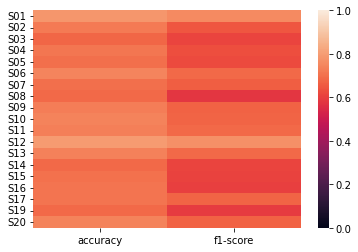

     class0 f1-score  class1 f1-score
S01         0.859438         0.520548
S02         0.827839         0.253968
S03         0.798587         0.173913
S04         0.824675         0.181818
S05         0.816176         0.166667
S06         0.843206         0.285714
S07         0.801444         0.352941
S08         0.810458         0.093750
S09         0.832787         0.281690
S10         0.839344         0.309859
S11         0.831461         0.328358
S12         0.866667         0.560976
S13         0.835088         0.356164
S14         0.805461         0.173913
S15         0.818482         0.126984
S16         0.828479         0.070175
S17         0.813953         0.351351
S19         0.807947         0.121212
S20         0.840678         0.276923


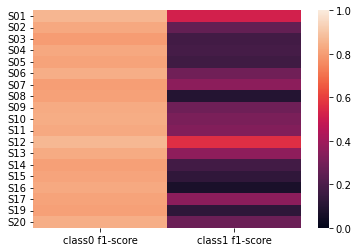

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

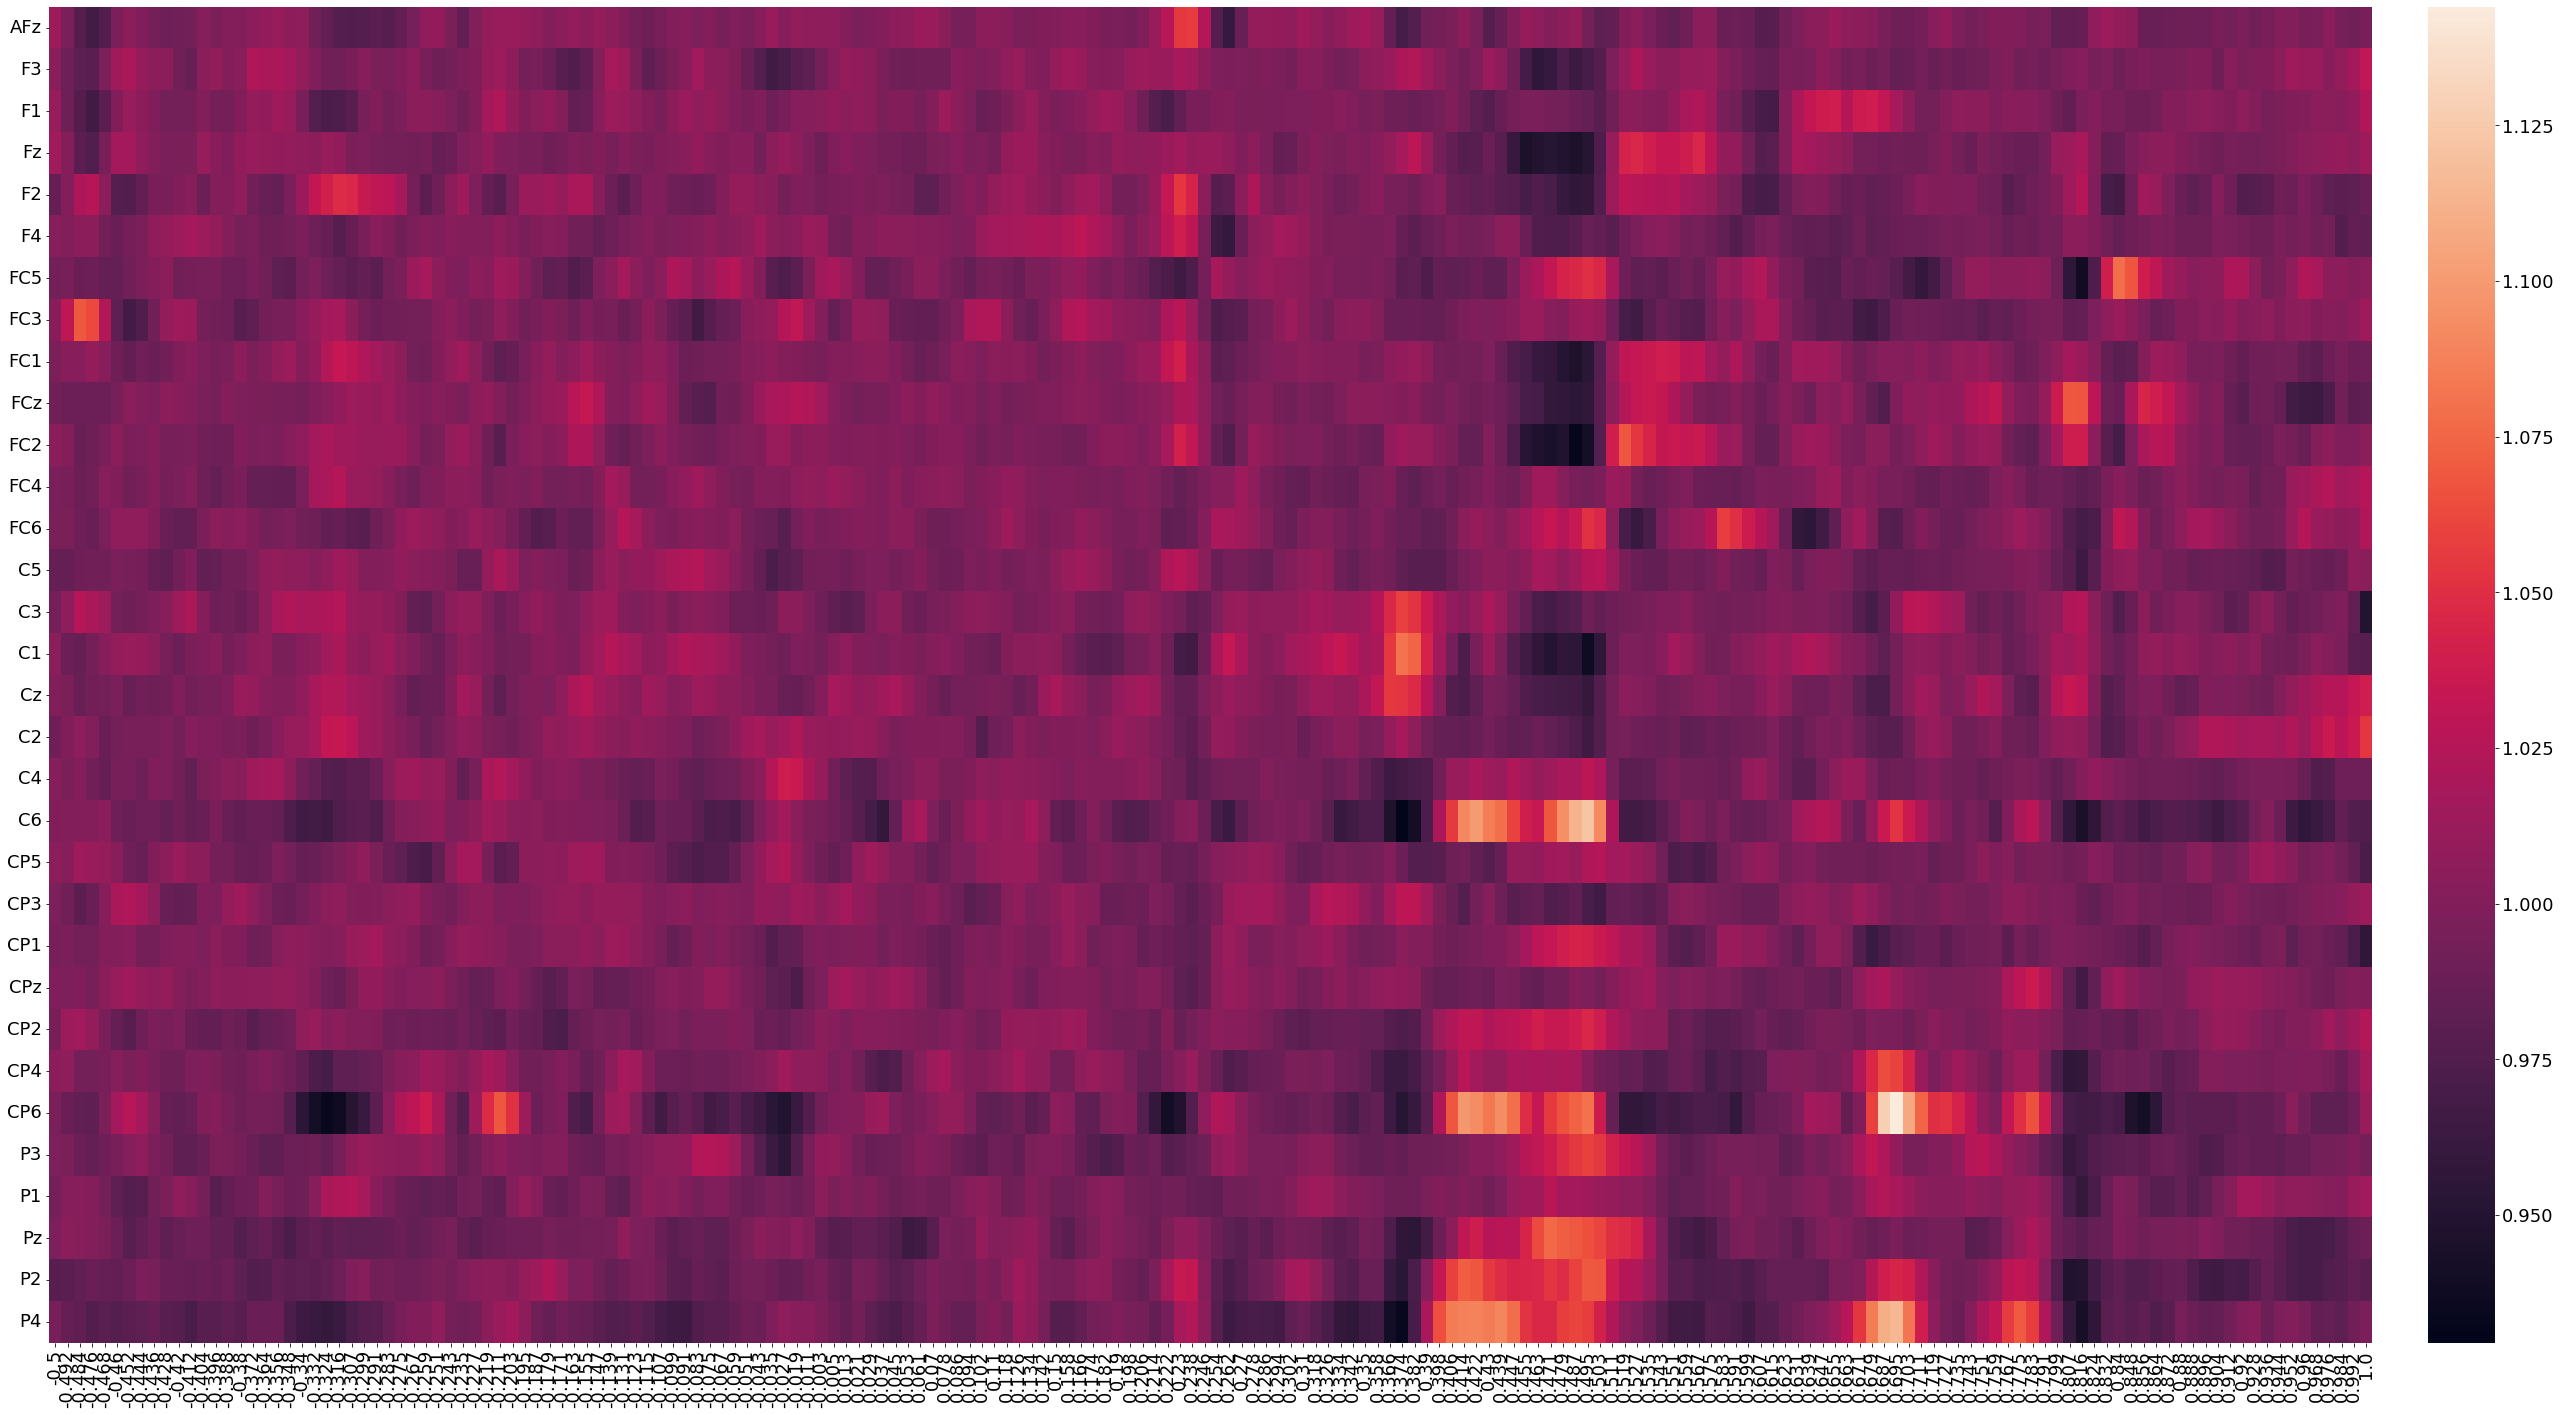

In [17]:
# fig, ax= plt.subplots(3,1)
fig =plt.figure()
sns.heatmap(pd.DataFrame(avg_w), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, 
            annot=False, cbar_kws={"pad":0.02})

# ax[0].set_title("AUC")

# sns.heatmap(pd.DataFrame(avg_grad["ROC"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[1],
#             annot=False, cbar_kws={"pad":0.02})
# ax[1].set_title("ROC")

# sns.heatmap(pd.DataFrame(avg_grad["STD"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[2],
#             annot=False, cbar_kws={"pad":0.02})
# ax[2].set_title("STD")

# plt.suptitle("Relative Importance Estimate of Time Series")
fig.set_figwidth(40)
fig.set_figheight(20)
plt.tight_layout()

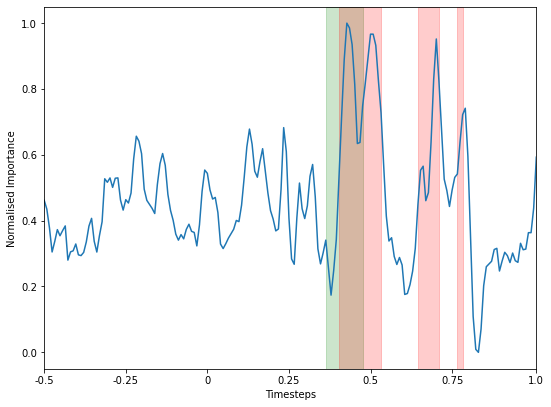

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

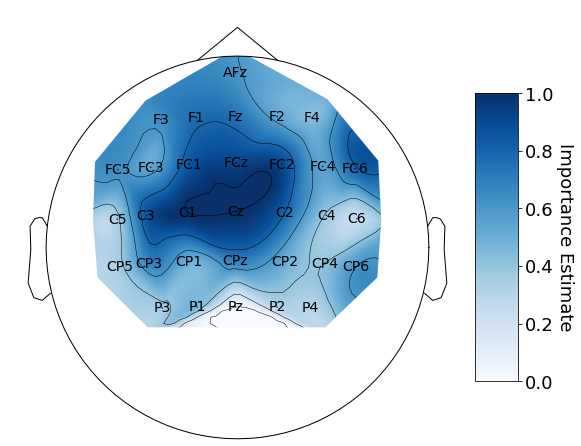

In [11]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)